<h2> Nauczanie maszynowe/Ćwiczenia3

In [1]:
import torch
from utils import visualize_optimizer
from checker import test_optimizer

# w utils i checker dodałam import torch bo nie działało

Definiujemy klasę rodzic dla kolejnych metod.

In [2]:
from typing import List

class Optimizer:
    """Klasa bazowa dla optymalizatorów"""
    
    def __init__(self, initial_params):
        # store model weights
        self.params = initial_params
    
    def step(self):
        """w self.params będą aktualizacje wag"""
        raise NotImplementedError()
         
    def zero_grad(self):
        """Torch akumuluje gradient, więc go zerujemy po kazdej aktualizacji"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

### Metoda spadku gradientu

<font size="+2"> $$\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}(\theta_t)$$  </font><br>

In [3]:
class GradientDescent(Optimizer):
    
    def __init__(self, initial_params: List[torch.tensor], learning_rate):
        super().__init__(initial_params) #wywołuje z inital_params z parent
        self.learning_rate = learning_rate
    
    @torch.no_grad() #wyłącza śledzenie tych operacji (nie chcemy liczyc gradientu z gradientu)
    def step(self):
        for param in self.params:
            param -= self.learning_rate * param.grad

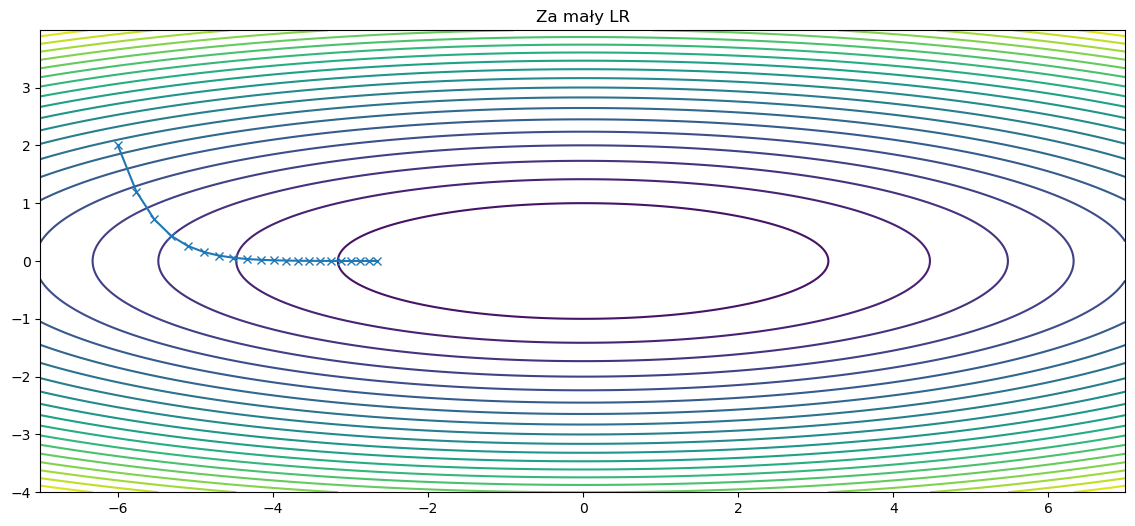

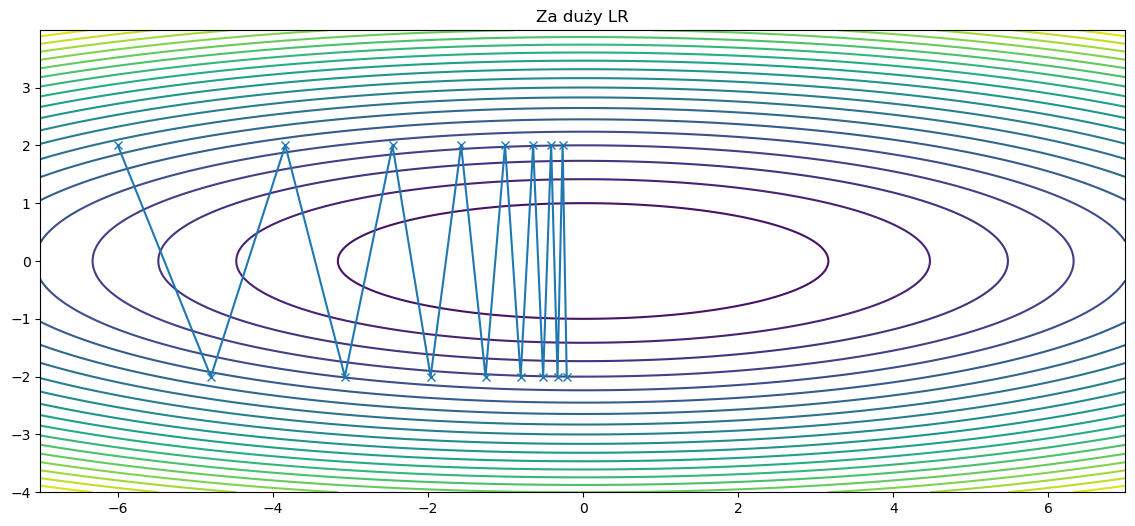

In [4]:
visualize_optimizer(GradientDescent, n_steps=20, learning_rate=0.1, title='Za mały LR')
visualize_optimizer(GradientDescent, n_steps=15, learning_rate=0.5, title='Za duży LR')

### Momentum
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Momentum (zawsze < 1, typowo 0.9)

Zmiany dokonywane są na podstawie wektora "pędu" (ang. *momentum*) $\Delta$, który rośnie jeżeli dokonujemy zmian w tym samym kierunku.

<font size="+2"> $$ \Delta_{t+1} = \gamma  \Delta_{t} + \eta \nabla_\theta \mathcal{L}(\theta_t) $$ </font><br>
<font size="+2"> $$ \theta_{t+1} = \theta_{t} - \Delta_{t+1} $$ </font>

#### Uwagi
* $\Delta_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* pęd (kierunku zmian) bierze pod uwagę poprzednie kierunki aktualizacji
* To tak, jakbyśmy popychali kulkę po powierzchni błędów:

ten sam kierunku — kulka się rozpędza,

inny kierunek — pęd hamuje gwałtowne skręty
* $\gamma  \Delta_{t}​$ to pamięć poprzedniego kierunku

<h4> Zadanie1: Uzupełnij definicję poniżej klasy.

In [5]:
class Momentum(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        
        self.deltas = []
        
        for param in self.params:
            self.deltas.append(torch.zeros_like(param))
              
    @torch.no_grad()
    def step(self):
        for param, delta in zip(self.params, self.deltas):
            # aktualizacja pędu
            # [:] zaktualizuj zawartość istniejącego tesnora - w self.deltas, nie zmienna lokalną w pętli
            delta[:] = self.gamma * delta + self.learning_rate * param.grad
            # aktualizacja parametru
            param -= delta

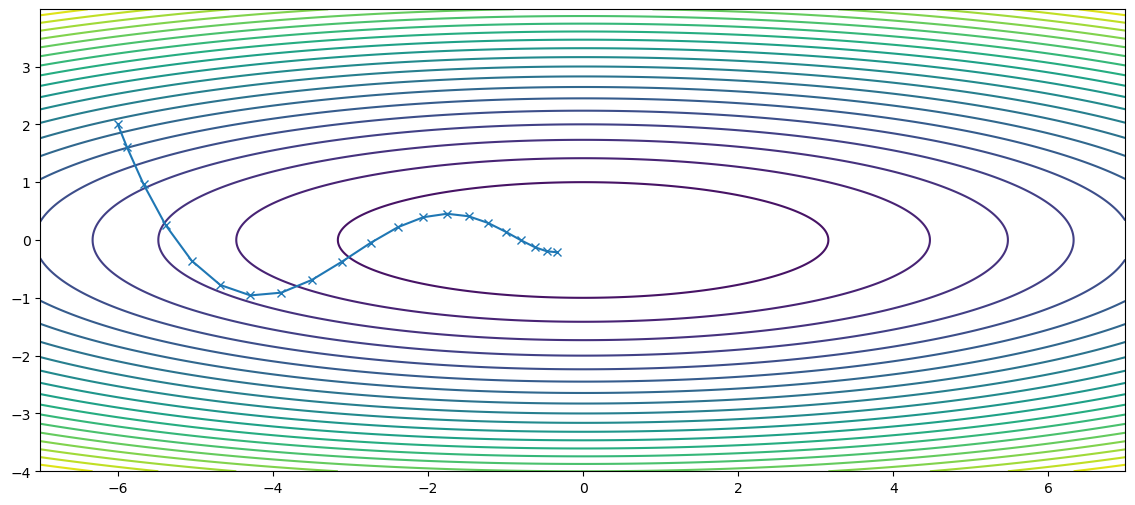

In [6]:
visualize_optimizer(Momentum, n_steps=20, learning_rate=0.05, gamma=0.8)

### Adagrad  
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

W każdym korku adaptujemy stałą uczenia $\eta$ dla każdego z wymiarów wag na podstawie sumy kwadratów dotychczasowych gradientów.

<font size="+2"> $$ \displaystyle  G_t = \sum_{i = 1}^{t} \big(\nabla_\theta \mathcal{L}(\theta_i)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



<font size="+0"> gdzie $G_t$ to suma kwadratów gradientów $\nabla_\theta \mathcal{L}(\theta_i)^2$ dla kroków $i = 1, .., t$ </font>

##### Uwagi
* $G_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

<h4> Zadanie2: Uzupełnij definicję poniżej klasy.

In [7]:
class Adagrad(Optimizer):
    
    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
                
        self.gs = []

        for param in self.params:
             self.gs.append(torch.zeros_like(param))
    
    @torch.no_grad()
    def step(self):
        for param, g in zip(self.params, self.gs):
            g[:] += param.grad**2
            param -= (self.learning_rate / torch.sqrt(g + self.epsilon))*param.grad

In [8]:
test_optimizer(Adagrad)

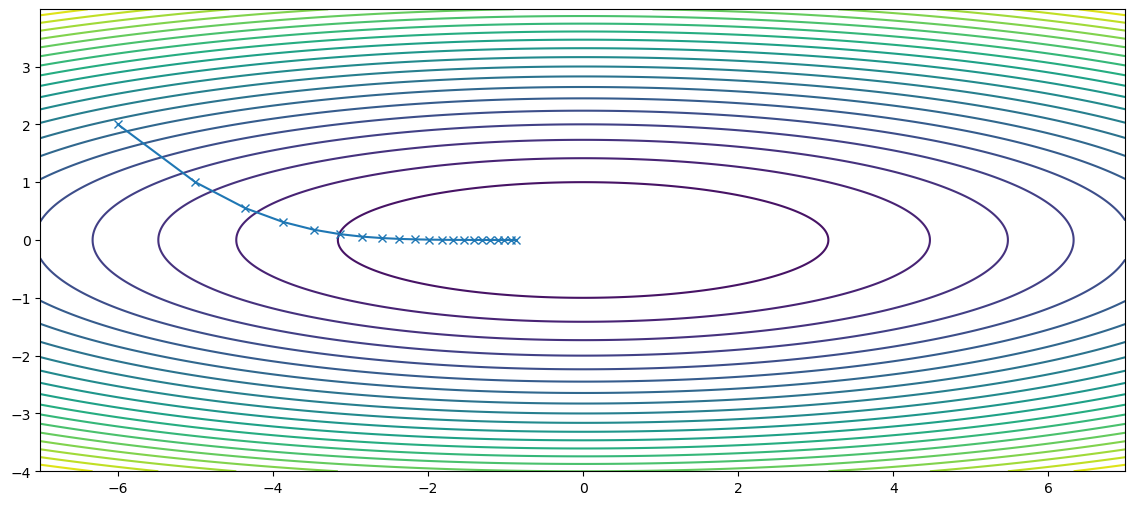

In [9]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=1.0, epsilon=1e-8)

### RMSProp  
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

Analogicznie dla algorytmu *Adagrad* adaptujemy stałą uczenia, lecz tym razem zamiast sumy, robimy to średnią kroczącą ze współczynnikiem $\gamma$.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



gdzie $H_t$ to średnia krocząca kwadratów gradientów $(\nabla_\theta \mathcal{L}(\theta_t))^2$ z kroków $0, 1, ..., t$ ze współczynnikiem $\gamma$.

#### Uwagi
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

<h4> Zadanie3: Uzupełnij definicję poniżej klasy.

In [10]:
class RMSProp(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.hs = []
        for param in self.params:
             self.hs.append(torch.zeros_like(param))
        
    @torch.no_grad()
    def step(self):
        for h, param in zip(self.hs, self.params):
            h[:] = self.gamma * h + (1- self.gamma) * param.grad**2
            param -= (self.learning_rate/torch.sqrt(h + self.epsilon)) * param.grad

In [11]:
test_optimizer(RMSProp)

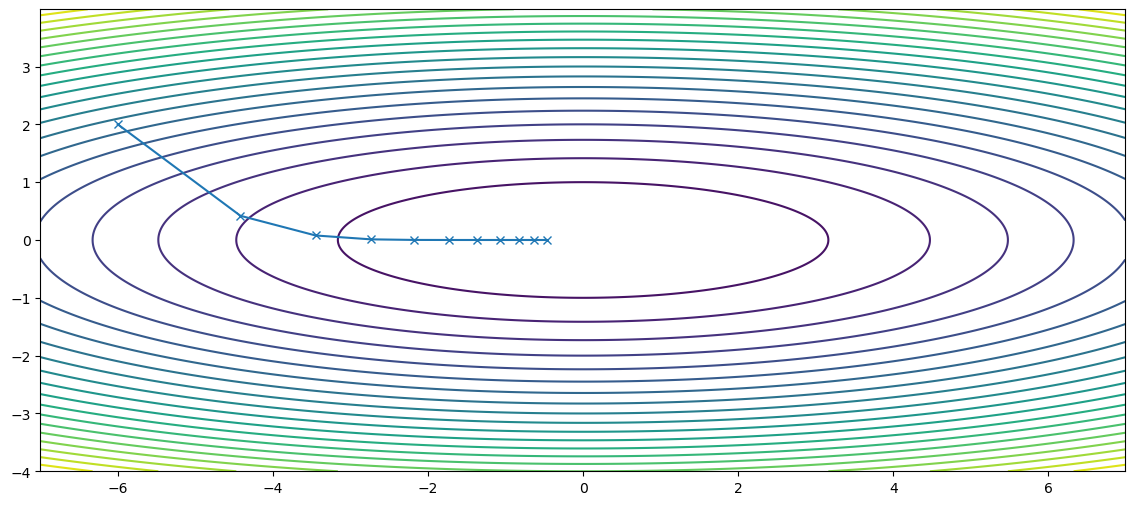

In [12]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

### Adadelta  
Hiperparametry:
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 oraz rozpoczęcia uczenia (typowo $10^{-8}$ do $10^{-2}$)

Eliminujemy stałą uczenia $\eta$ i sprawiamy, że "prędkość" poprawek jest podobna do faktycznych poprawek uzależniając krok uczenia od średniej kroczącej poprzednich poprawek.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \Delta_{t+1} = \frac{\sqrt{D_{t} + \epsilon}}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \Delta_{t+1} $$ </font>

<font size="+2"> $$ D_{t+1} = \gamma D_{t} + (1 - \gamma) \Delta_{t+1}^2 $$ </font>

#### Uwagi:
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $D_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

<h4> Zadanie4: Uzupełnij definicję poniżej klasy.

In [13]:
class Adadelta(Optimizer):
    def __init__(self, initial_params, gamma, epsilon):
        super().__init__(initial_params)
        self.gamma = gamma
        self.epsilon = epsilon

        self.hs = []
        self.deltas = []
        self.ds = []

        for param in self.params:
             self.hs.append(torch.zeros_like(param))
             self.deltas.append(torch.zeros_like(param))
             self.ds.append(torch.zeros_like(param))

    @torch.no_grad()
    def step(self):
        for param, h, delta, d in zip(self.params, self.hs, self.deltas, self.ds):
            h[:] = self.gamma * h + (1 - self.gamma) * param.grad**2
            delta[:] = (torch.sqrt(d+self.epsilon)/torch.sqrt(h+self.epsilon)) * param.grad
            param -= delta
            d[:] = self.gamma * d + (1-self.gamma) * delta**2

In [14]:
test_optimizer(Adadelta)

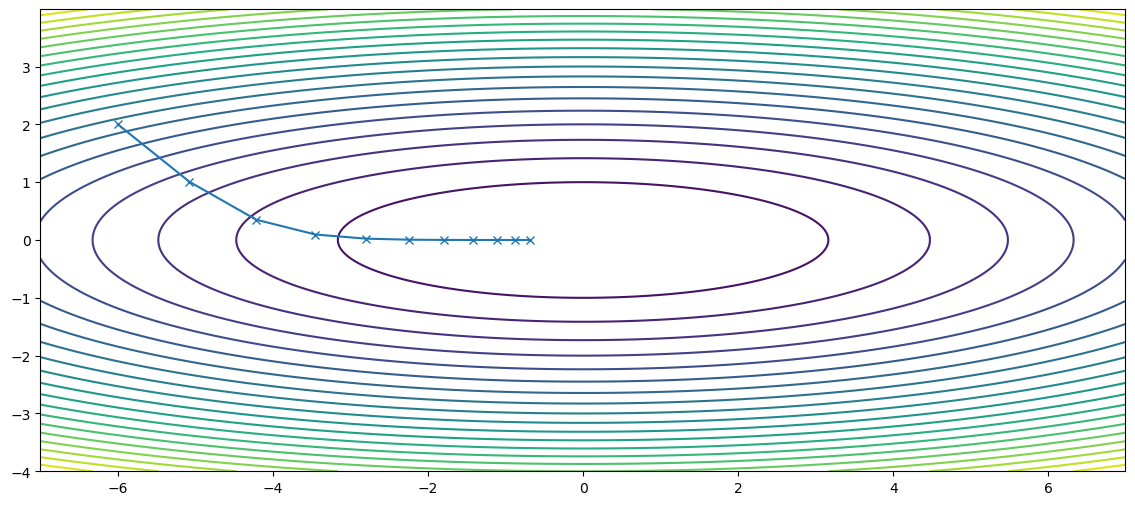

In [ ]:
visualize_optimizer(Adadelta, n_steps=10, gamma=0.9, epsilon=1e-1)
# w referecji wykres wygląda inaczej, ale jest tez inna ilosc kroków niż 10 więc nie wiem czy sie tym sugerować 
# bo kod wygląda dobrze i był zrobiony analogicznie do wczesniejszych

### Adam 

Hiperparametry:
* $\eta$ - Learning Rate (typowo 0.001)
* $\beta_1$ - współczynnik średniej kroczącej pierwszego momentu (typowo 0.9)
* $\beta_2$ - współczynnik średniej kroczącej drugiego momentu (typowo 0.999)
* $\epsilon$ - zapobiega dzieleniu przez zero (typowo $10^{-8}$)

Adaptujemy gradient dwiema średnimi kroczącymi, pierwszego $m$ i drugiego $v$ momentu. Na początku uczenia te średnie są bardzo zbiasowane do 0, stąd wprowadzane są poprawka $\hat{m}$ i $\hat{v}$, im dalej w procesie uczenia, tym te poprawki wprowadzają mniejsze zmiany.  

<font size="+2"> $$ m_{t+1} = \beta_1 m_{t} + (1 - \beta_1)  \nabla_\theta \mathcal{L}(\theta_t) $$ </font>
<font size="+2"> $$ v_{t+1} = \beta_2 v_{t} + (1 - \beta_2)  \big( \nabla_\theta \mathcal{L}(\theta_t) \big)^2 $$ </font>
<br>
<font size="+2"> $$  \hat{m} = \frac{m_{t+1}}{1 - \beta_1^{(t+1)}} $$ </font><br>
<font size="+2"> $$  \hat{v} = \frac{v_{t+1}}{1 - \beta_2^{(t+1)}} $$ </font>
<br>
<font size="+2"> $$ \theta_{t+1} = \theta_t - \eta \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon} $$ </font>

#### Uwagi
* $m_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $v_0 = \mathbf{0}$, wymiar taki sam jak $\theta$. 
* $\beta_1^{(t+1)}$ oraz $\beta_2^{(t+1)}$ to potęgowania.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.


<h4> Zadanie5: Uzupełnij definicję poniżej klasy.

In [16]:
class Adam(Optimizer):
   
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.n = 0
        
        self.m_hats = []
        self.v_hats = []
        
        self.ms = []
        self.vs = []

        for param in self.params:
            self.ms.append(torch.zeros_like(param))
            self.vs.append(torch.zeros_like(param))
            self.m_hats.append(torch.zeros_like(param))
            self.v_hats.append(torch.zeros_like(param))
        
    @torch.no_grad()
    def step(self):
        for m, v, m_hat, v_hat, param in zip(self.ms, self.vs, self.m_hats, self.v_hats, self.params):
            m[:] = self.beta1 * m + (1-self.beta1)*param.grad
            v[:] = self.beta2 * v + (1-self.beta2)*param.grad**2
            m_hat[:] = m / (1 - self.beta1**(self.n +1))
            v_hat[:] = v / (1 - self.beta2**(self.n +1))

            param -= self.learning_rate * (m_hat / (torch.sqrt(v_hat) + self.epsilon))

        self.n+=1

In [17]:
test_optimizer(Adam)

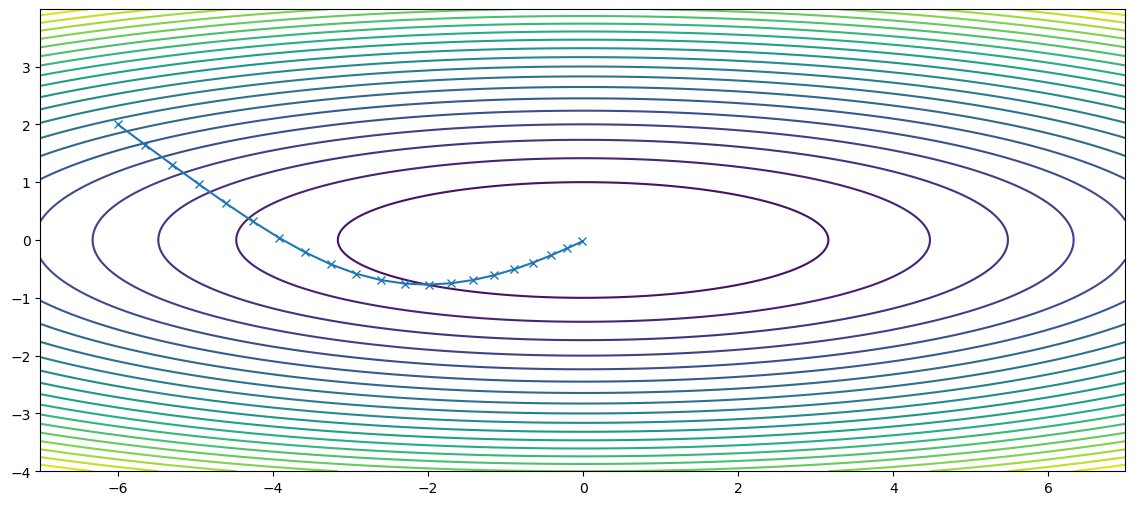

In [18]:
visualize_optimizer(Adam, n_steps=20, learning_rate=0.35, beta1=0.9, beta2=0.999, epsilon=1e-8)